## Merge and analyze NOAA_df and downed_df


In [1]:
# Import the following libraries:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from NOAA import get_cleaned_NOAA_df
from reason_data import downed 

In [2]:
# Quick look at the data size for reference
downed_df = downed()
NOAA_df = get_cleaned_NOAA_df()

print("downed_df: ",len(downed_df))
print("NOAA_df: ",len(NOAA_df))

downed_df:  900
NOAA_df:  11897


## Now join downed_df and NOAA_df
The NOAA data contains multiple lines per day.  In order to limit lines from downed_df being duplicated after the merge,
use the **pandas.merge_asof** method.<br>This will merge the downed_df on the nearest prior datetime as the NOAA_df.

In [3]:
downed_df = downed_df.sort_values('downed')
NOAA_df = NOAA_df.sort_values('DATE')

def merge_downed_and_NOAA():
    # Merge and assign each downed event the most recent NOAA data before that event
    # merge_asof is like a left-join but matches on the nearest key rather than the equal keys. 
    merged_df = pd.merge_asof(
        downed_df,
        NOAA_df,
        left_on='downed',
        right_on='DATE',
        direction='backward'
    )
    return merged_df
merged_df = merge_downed_and_NOAA()

# Check to make sure merge operation worked correctly. 
# The dates in 'downed' (from downed_df) and 'DATE' (from NOAA_df) should be the same.
merged_df[['downed','DATE']]

,downed,DATE
0,2019-09-25 07:11:00,NaT
1,2022-03-28 10:38:00,NaT
2,2023-08-24 14:27:00,NaT
3,2023-09-20 10:47:00,NaT
4,2023-09-20 11:57:00,NaT
...,...,...
895,2024-12-13 15:39:00,2024-12-13 14:53:00
896,2024-12-13 16:00:00,2024-12-13 15:53:00
897,2024-12-13 18:09:00,2024-12-13 17:53:00
898,2024-12-13 19:17:00,2024-12-13 18:53:00


### There are still some rows in merged_df that contain NaNs!

In [4]:
nan_rows = merged_df[merged_df['DATE'].isna()]
nan_rows['downed']

0   2019-09-25 07:11:00
1   2022-03-28 10:38:00
2   2023-08-24 14:27:00
3   2023-09-20 10:47:00
4   2023-09-20 11:57:00
5   2023-10-26 09:09:00
6   2023-12-12 12:04:00
7   2023-12-21 11:18:00
8   2023-12-21 16:33:00
Name: downed, dtype: datetime64[ns]

### All of these events began prior to the NOAA data, so remove these rows.

In [5]:
merged_df = merged_df.drop(nan_rows.index)
print("merged_df: ",len(merged_df), " rows")

merged_df:  891  rows


### The 50 hour, 100 hour, and Annual inspections occur on a schedule, and the Unspecified reasons don't give any indications, so all those can be removed from analysis.

In [6]:
final_merged_df = merged_df.loc[merged_df['reason'].isin(['50 Hr Inspect', '100 Hr Inspect', 'Annual Inspect','Unspecified']) == False]
final_merged_df.head()

,resource,downed,upped,duration,reason,reported duration,DATE,altimeter,dew_point,temperature,...,wind_speed,avg_altimeter_prev_5d,avg_dew_point_prev_5d,avg_temperature_prev_5d,avg_precipitation_prev_5d,avg_humidity_prev_5d,avg_visibility_prev_5d,avg_wind_dir_prev_5d,avg_gust_speed_prev_5d,avg_wind_speed_prev_5d
9,WMU34 N57JW,2024-01-04 11:40:00,2024-01-04 15:20:00,0 days 03:40:00,Avionics,0 days 03:42:00,2024-01-04 10:53:00,30.34,14.0,27.0,...,6.0,30.101452,26.903226,32.016129,0.000847,81.935484,8.727823,246.733871,21.260702,9.403226
17,WMU51 N923JW,2024-01-16 15:27:00,2024-01-19 09:17:00,2 days 17:50:00,Avionics,2 days 17:48:00,2024-01-16 15:06:00,29.97,-4.0,5.0,...,16.0,29.678063,11.834507,16.866197,0.009756,80.411972,4.592870,216.971831,28.160753,16.957746
19,WMU44 N80GD,2024-01-17 16:22:00,2024-01-18 08:56:00,0 days 16:34:00,Airframe,0 days 16:36:00,2024-01-17 15:53:00,29.89,5.0,16.0,...,17.0,29.698453,7.892086,13.435252,0.008615,78.377698,4.683903,226.402878,28.433671,17.863309
21,WMU52 N851ST,2024-01-19 15:39:00,2024-01-21 12:49:00,1 days 21:10:00,Engine,1 days 21:12:00,2024-01-19 15:23:00,30.10,11.0,21.0,...,7.0,30.009378,5.280000,11.622222,0.002933,75.617778,6.722222,218.044444,25.813721,11.182222
22,WMU42 N94RS,2024-01-20 15:23:00,2024-01-21 12:20:00,0 days 20:57:00,Engine,0 days 21:00:00,2024-01-20 14:53:00,30.35,14.0,24.0,...,16.0,30.027588,7.456140,13.675439,0.002895,76.280702,6.629386,210.350877,26.863577,9.978070


### The dataframe is ready to analyze.  Start with a SPLOM.
Use Seaborn's pairplot to create a SPLOM.

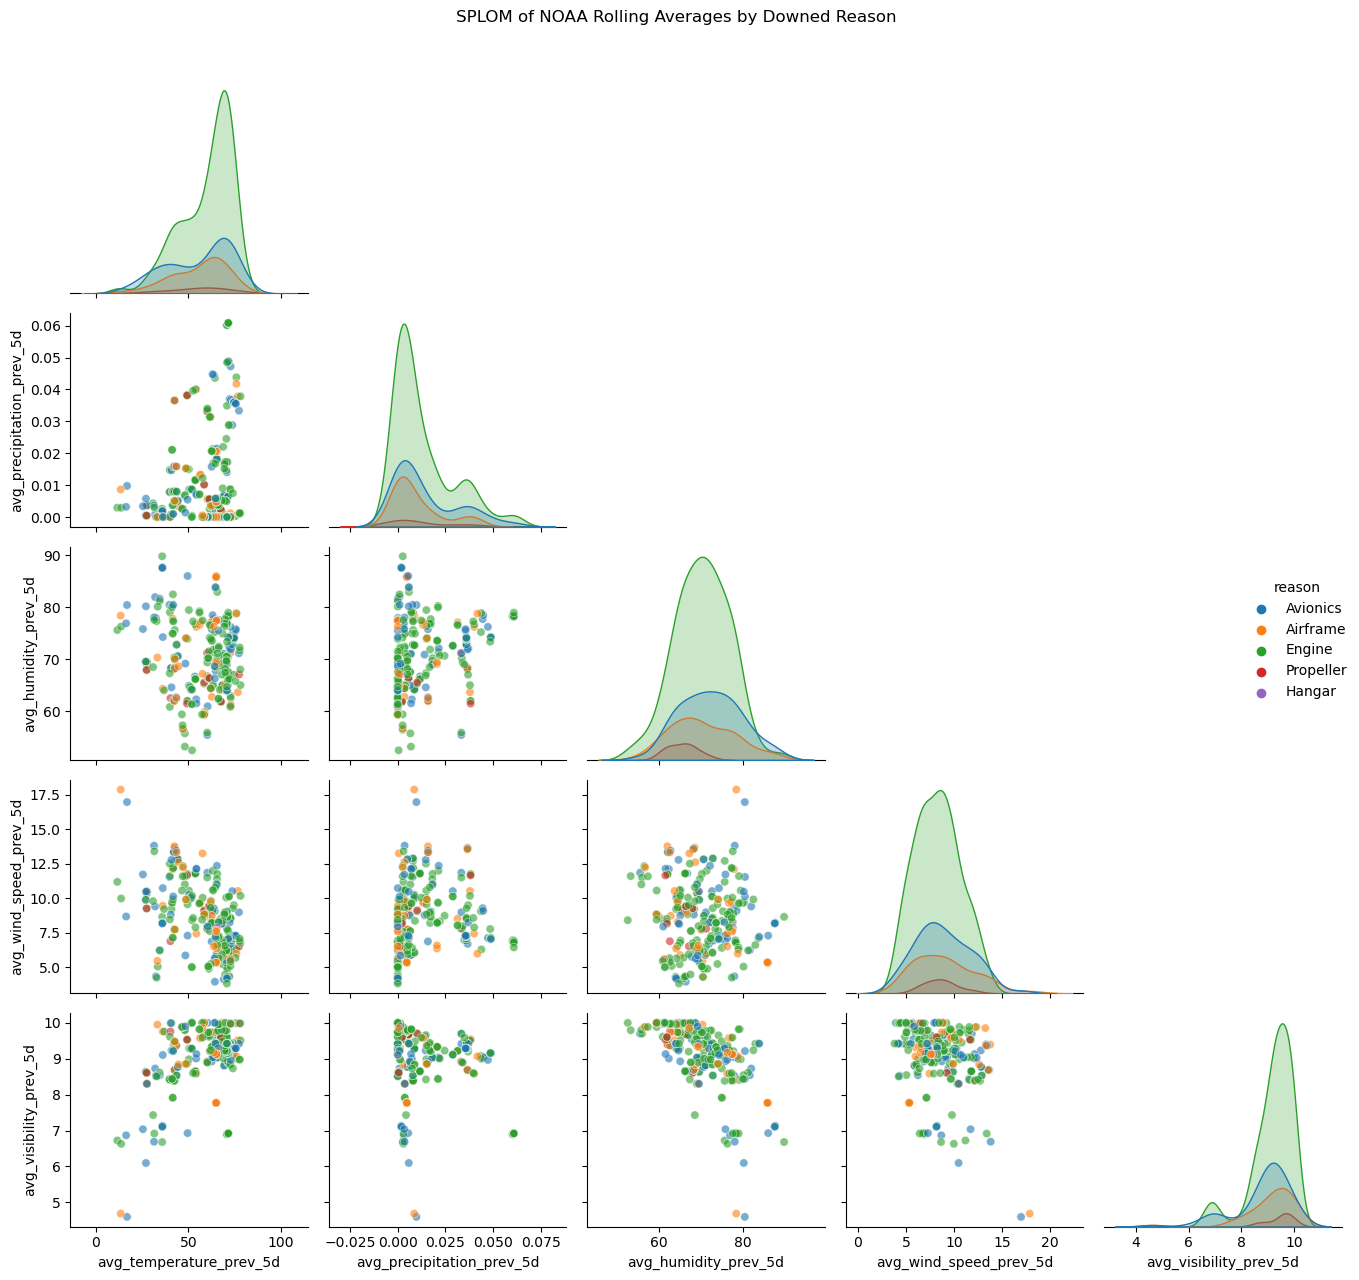

In [7]:
# There are a lot of weather columns, so pick just a few to start.
important_cols = [
    'avg_temperature_prev_5d',
    'avg_precipitation_prev_5d',
    'avg_humidity_prev_5d',
    'avg_wind_speed_prev_5d',
    'avg_visibility_prev_5d',
]

def weather_splom(columns):
    sub_df = final_merged_df[important_cols + ['reason']].dropna()
    sns.pairplot(
        sub_df,
        vars=important_cols,
        hue='reason',
        corner=True,
        plot_kws={'alpha': 0.6}
    )

    plt.suptitle("SPLOM of NOAA Rolling Averages by Downed Reason", y=1.02)
    plt.tight_layout()
    plt.show()
    
weather_splom(important_cols)

### The results show a relation between downed events and weather conditions.
It looks like there might be a link among good visibility, low precipitation, and warm weather causing an increase in downed events. Probably more flights during that time!

Use Seaborn's kdeplot to recreate the diagonal charts from the above SPLOM.

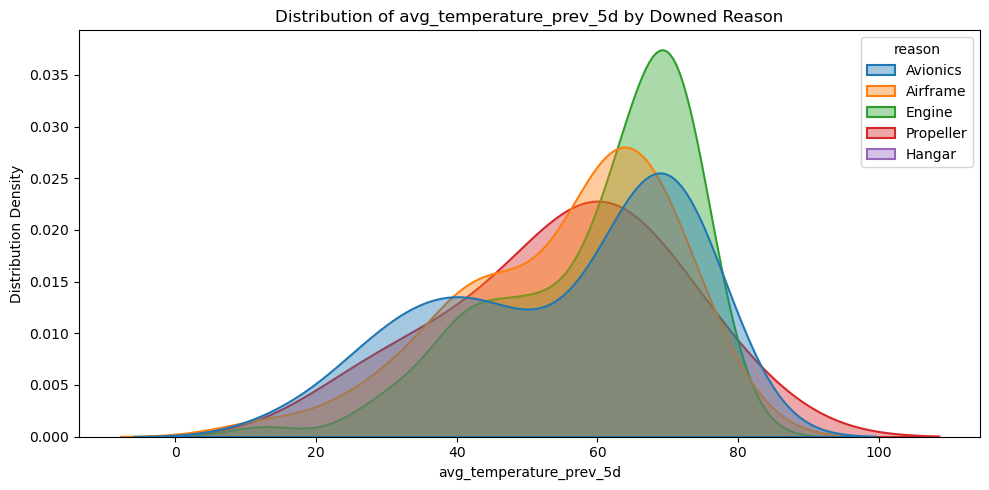

In [8]:
# KDE plot template for weather data in final_merged_df
# Use this function for any/all weather features to get a closer look.
def plot_kde_by_reason(x):

    sub_df = final_merged_df[[x, 'reason']].dropna()

    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=sub_df,
        x=x,
        hue='reason',
        fill=True,
        common_norm=False,
        alpha=0.4,
        linewidth=1.5,
        palette='tab10'
    )

    plt.title(f'Distribution of {x} by Downed Reason')
    plt.xlabel(x)
    plt.ylabel('Distribution Density')
    plt.tight_layout()
    plt.show()
plot_kde_by_reason('avg_temperature_prev_5d')

In [9]:
# Get the number of each downed reason
reason_counts = merged_df['reason'].value_counts()
print(reason_counts)

reason
Unspecified       377
50 Hr Inspect     228
Engine            167
Avionics           67
Airframe           40
Propeller           8
Annual Inspect      2
100 Hr Inspect      1
Hangar              1
Name: count, dtype: int64


### The resource column in final_merged_df contains the aircraft's WMU# and tail number
How can we add that to the analysis?

In [20]:
# Get a count of the number of aircraft used in the dataset and the number
# of times each one was downed for a maintenance problem
aircraft_counts = final_merged_df['resource'].value_counts()
print("Aircraft Count: ", len(aircraft_counts))
aircraft_counts


Aircraft Count:  27


resource
WMU50 N191JG    18
WMU44 N80GD     17
WMU34 N57JW     16
WMU56 N91SA     16
WMU35 N481RA    14
WMU48 N156CS    14
WMU37 N70RB     13
WMU47 N53PB     13
WMU43 N54DN     12
WMU53 N36PL     12
WMU49 N81EZ     12
WMU36 N22WU     12
WMU41 N267DS    11
WMU54 N65TH     11
WMU57 N651BS    11
WMU42 N94RS     10
WMU58 N173WM     9
WMU46 N93TA      9
WMU39 N54SJ      9
WMU31 N1281      7
WMU52 N851ST     7
WMU40 N861SH     7
WMU38 N746TM     6
WMU32 N48TG      5
WMU51 N923JW     4
WMU55 N140AF     4
WMU33 N154WF     4
Name: count, dtype: int64

### Build a bar chart that shows the breakdown of each downed event by reason and separated for each aircraft
Use Seaborn's barplot

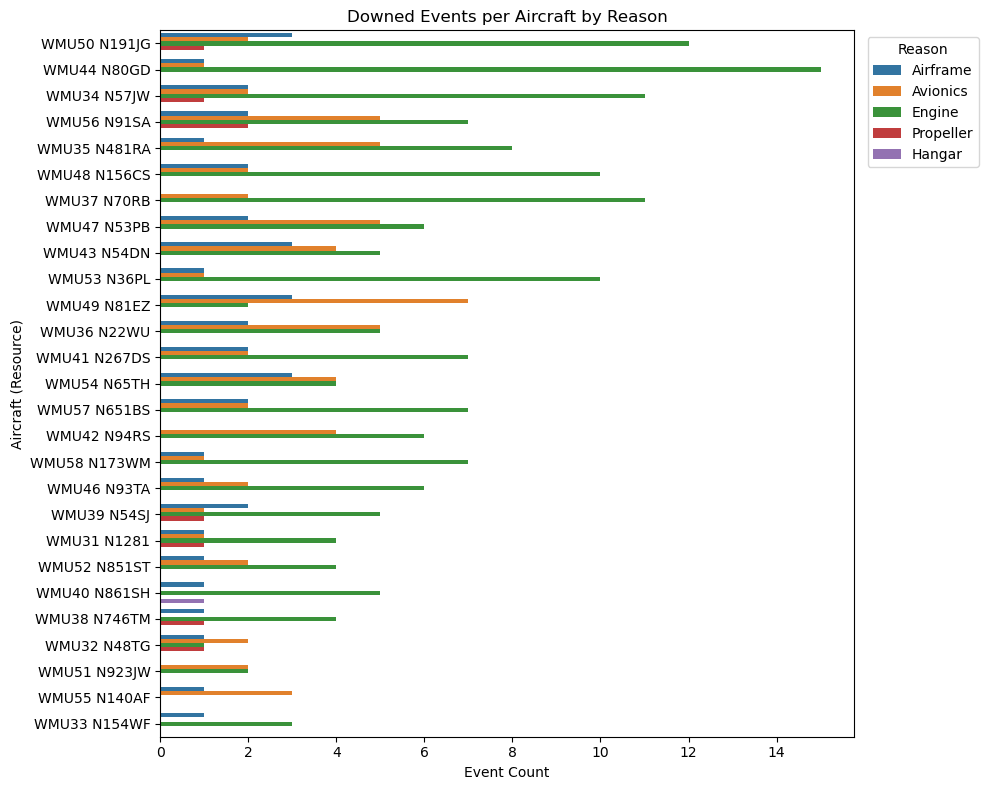

In [11]:
def downed_counts_by_aircraft_and_reason():
    # Count downed events per aircraft
    aircraft_counts = final_merged_df['resource'].value_counts()
    
    # Count how many times each aircraft was downed for each reason
    count_df = final_merged_df.groupby(['resource', 'reason']).size().reset_index(name='count')

    # Sort aircraft by total downed events for ordered plotting
    count_df['resource'] = pd.Categorical(count_df['resource'], categories=aircraft_counts.index, ordered=True)

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=count_df,
        y='resource',
        x='count',
        hue='reason',
        palette='tab10'
    )

    plt.title("Downed Events per Aircraft by Reason")
    plt.xlabel("Event Count")
    plt.ylabel("Aircraft (Resource)")
    plt.legend(title='Reason', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

downed_counts_by_aircraft_and_reason()

### Use a stacked bar chart to make it easier to read


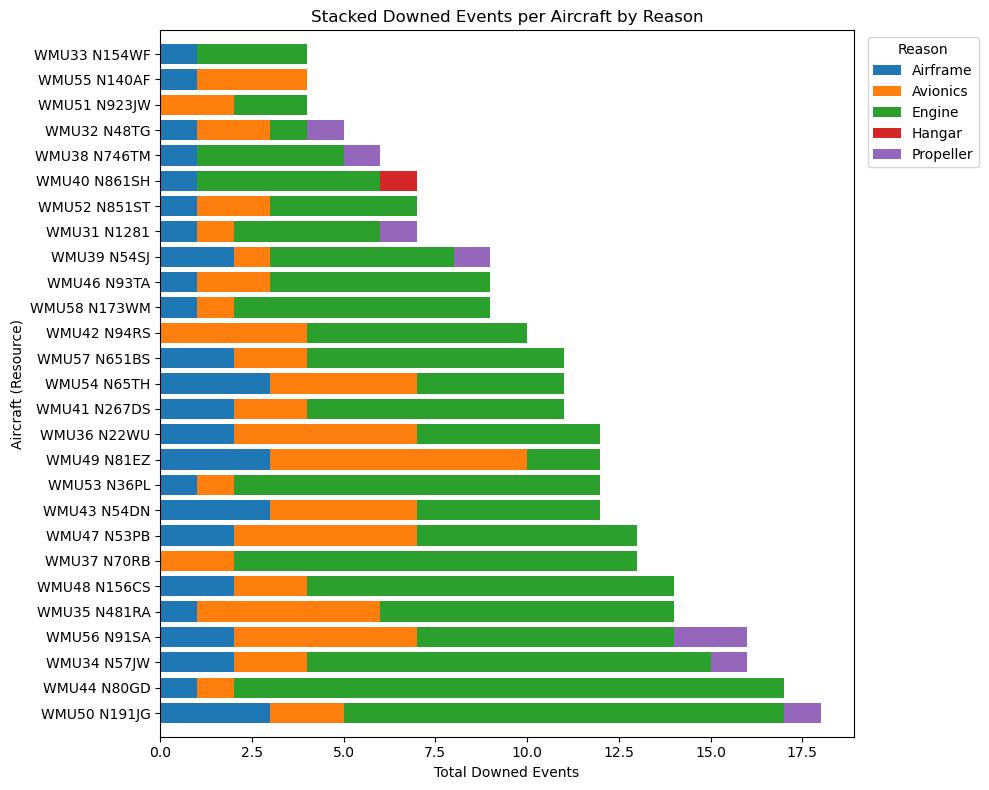

In [12]:
def stacked_downed_counts_by_aircraft_and_reason():
    # Count downed events per aircraft
    aircraft_counts = final_merged_df['resource'].value_counts()

    # Create pivot table of counts per (resource, reason)
    count_df = final_merged_df.groupby(['resource', 'reason']).size().unstack(fill_value=0)

    # Order aircraft by total downed counts using aircraft_counts
    count_df = count_df.loc[aircraft_counts.index]

    # Plot
    plt.figure(figsize=(10, 8))
    left = pd.Series([0] * len(count_df), index=count_df.index)
    colors = plt.cm.tab10.colors

    for i, reason in enumerate(count_df.columns):
        counts = count_df[reason]
        plt.barh(count_df.index, counts, left=left, label=reason, color=colors[i % len(colors)])
        left += counts

    plt.xlabel("Total Downed Events")
    plt.ylabel("Aircraft (Resource)")
    plt.margins(y=0.02)
    plt.title("Stacked Downed Events per Aircraft by Reason")
    plt.legend(title='Reason', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

stacked_downed_counts_by_aircraft_and_reason()

## Take a look at durations of downed events
Make a horizontal bar chart with Seaborn's barplot

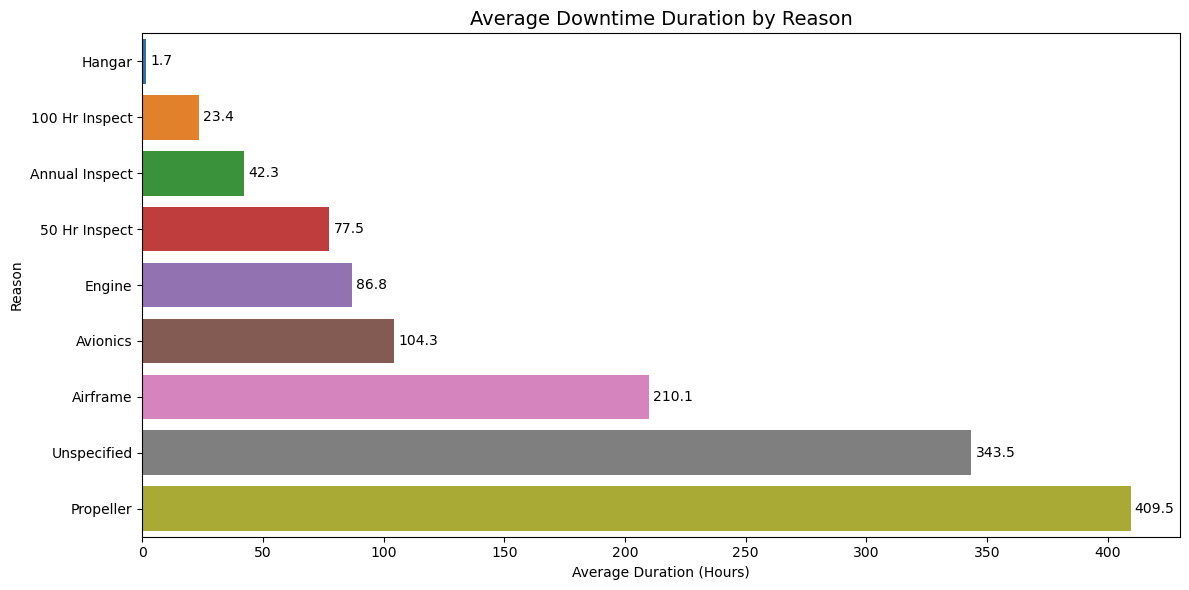

In [22]:
def downtime_barchart(df):
    avg_duration = df.groupby('reason')['duration'].mean().reset_index()
    avg_duration['duration_hours'] = avg_duration['duration'].dt.total_seconds() / 3600
    
    plot_data = avg_duration.reset_index()
    plot_data = plot_data.sort_values('duration_hours', ascending=True)
        
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(
        data=plot_data,
        y='reason',
        x='duration_hours',
        palette='tab10'
    )
    
    for i in barplot.containers:
        barplot.bar_label(i, fmt='%.1f', label_type='edge', padding=3)
    
    plt.title('Average Downtime Duration by Reason', fontsize=14)
    plt.xlabel('Average Duration (Hours)')
    plt.ylabel('Reason')
    plt.tight_layout()
    return plt.show()
downtime_barchart(downed_df)